In [105]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
from scipy import optimize
import time
import functools
from multiprocessing import Pool
#from cyipopt import minimize_ipopt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

random.seed(10)


In [106]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/eq_price_new"
# = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/eq_price_ch3"

In [107]:
data = pd.read_csv(os.path.join(input_dir,r"welfare_eq_result_update_const_new.csv"))

In [108]:
list(data.columns)

['index',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_st

Text(0.5, 1.0, 'Actual prices vs. Status Quo Equiligirum Prices')

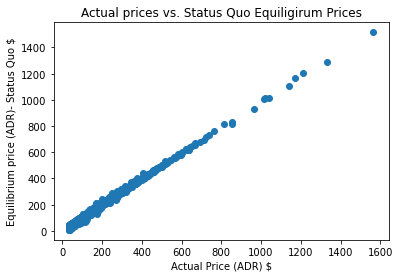

In [109]:
plt.scatter(data["ADR"],data["price_ne"])
plt.xlabel("Actual Price (ADR) $")
plt.ylabel("Equilibrium price (ADR)- Status Quo $")
plt.title("Actual prices vs. Status Quo Equiligirum Prices")

In [110]:
data[["ADR","price_ne"]].describe()

,ADR,price_ne
count,5597.000000,5597.000000
mean,141.570217,141.918005
std,96.118163,95.217815
min,34.083241,7.304442
25%,85.236818,85.532135
50%,119.546934,120.224608
75%,170.744239,170.809152
max,1563.839872,1516.132598


In [111]:

alpha = -0.012
sigma = 0.5396
rating_param = 0.073

occ_upper= 88

In [112]:
miami = data[data["Market"]=="Miami/Hialeah, FL"]

In [113]:
(miami["market_share_ne"]-miami["market_share_cf"]).describe()

count    734.000000
mean       0.000110
std        0.004337
min       -0.030796
25%       -0.000682
50%        0.000002
75%        0.000401
max        0.035273
dtype: float64

# Calculate marginal cost and total cost

In [114]:
# Status Quo marginal cost

#data["occ_ne"] = (data["demand_ne"]*100/30)/data["capacity"]

data_lower = data[data["demand_ne"]<=data["q_upper"]]

data_upper = data[data["demand_ne"]>data["q_upper"]]

data_lower["excess_demand"] = 0
data_lower["cost_ne"] = (192.39814102368837+data_lower["hotel_fixed_effect"]+data_lower["market_time_fixed_effect"])*\
                           data_lower["demand_ne"]
data_upper["excess_demand"] = data_upper["demand_ne"]-data_upper["q_upper"]
data_upper["cost_ne"] = (192.39814102368837+data_upper["hotel_fixed_effect"]+data_upper["market_time_fixed_effect"])*\
                           data_upper["q_upper"]+0.5*0.043841100663268406*(data_upper["excess_demand"]**2)


data= pd.concat([data_lower,data_upper],axis=0)

data = data.fillna(0)



In [115]:



data_lower = data[data["demand_cf"]<=data["q_upper"]]
data_upper = data[data["demand_cf"]>data["q_upper"]]

data_lower["excess_demand"] = 0
data_lower["cost_cf"] = (192.39814102368837+data_lower["hotel_fixed_effect"]+data_lower["market_time_fixed_effect"])*\
                           data_lower["demand_cf"]
data_upper["excess_demand"] = data_upper["demand_cf"]-data_upper["q_upper"]
data_upper["cost_cf"] = (192.39814102368837+data_upper["hotel_fixed_effect"]+data_upper["market_time_fixed_effect"])*\
                           data_upper["q_upper"]+0.5*0.043841100663268406*(data_upper["excess_demand"]**2)

data = pd.concat([data_lower,data_upper],axis=0)



# Calculate Consumer Surplus

In [116]:
data["r_greater_exante"] = data["exante_rating"]<data["Rating"]

#df["market_share_percent_diff"] = (df["market_share_cf"] - df["market_share"])/df["market_share"]


In [117]:
# calculate walfare
data["market_share_cf_delta_diff"] = data["market_share_cf"]*(rating_param*(data["Rating"] - data["exante_rating"])+alpha*(data["price_ne"]-data["price_cf"]))

l=[]
for i in (0,1,2):
    
    df_temp = data[data["Market"]==data["Market"].unique()[i]]
    diff = df_temp.groupby(["month","year"])["market_share_cf_delta_diff"].sum().reset_index().rename(columns={"market_share_cf_delta_diff":"diff_term"})
    temp = df_temp.merge(diff,on=["month","year"], how="left")
    l.append(temp)
    
df = pd.concat(l,axis=0)


In [118]:
df_cs = df[["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term","market_size"]].drop_duplicates()

df_cs["cs"] = (np.log(1+df_cs["D_g_sum_ne"]) - np.log(1+df_cs["D_g_sum_cf"])-df_cs["diff_term"])/alpha


In [119]:
df_cs["month_cs"] = df_cs["cs"]*df_cs["market_size"]

cs_result = df_cs.groupby("Market")["month_cs"].sum()/1000000
cs_result = cs_result.reset_index("Market")
cs_result.transpose()


,0,1,2
Market,"Chicago, IL","Houston, TX","Miami/Hialeah, FL"
month_cs,-0.918564,-9.187432,-3.448994


In [120]:
alpha

-0.012

In [121]:
data[(data["month"]==2)&(data["Market"]=="Miami/Hialeah, FL")&(data["shareid"]==4355335)][["Demand","demand_cf","market_share_cf","Rating","exante_rating","price_ne","price_cf"]]
                                                                                          

,Demand,demand_cf,market_share_cf,Rating,exante_rating,price_ne,price_cf
4971,31943.0,33196.400438,0.101854,4.23088,3.808161,446.19851,456.744963


In [122]:
((4.23088-4.232462)*rating_param+alpha*(446.19851-463.545987))*0.081804

0.017019668885352026

# Calculate Revenue, Profit, Marginal Cost

In [123]:
df = data

In [124]:
df["Revenue_cf"] = df["market_share_cf"]*df["market_size"]*df["price_cf"]
df["Revenue_ne"] = df["market_share_ne"]*df["market_size"]*df["price_ne"]
df["revenue_diff"] = df["Revenue_cf"] - df["Revenue_ne"]
df.groupby("Market")["revenue_diff"].sum()/1000000

Market
Chicago, IL         -22.111730
Houston, TX         -20.509655
Miami/Hialeah, FL   -34.901794
Name: revenue_diff, dtype: float64

In [125]:
#miami = df[df["Market"]=="Miami/Hialeah, FL"]
df["price_diff"] = df["price_cf"]-df["price_ne"]
df["market_share_diff"] = df["market_share_cf"]-df["market_share_ne"]

In [126]:
df.groupby(["Market","r_greater_exante"])["revenue_diff"].mean()

Market             r_greater_exante
Chicago, IL        False               67859.021269
                   True               -29567.855974
Houston, TX        False               11791.411000
                   True               -18756.463523
Miami/Hialeah, FL  False              -50253.275382
                   True               -46612.706476
Name: revenue_diff, dtype: float64

In [127]:
df.groupby(["Market","r_greater_exante"])["market_share_diff"].mean()*100

Market             r_greater_exante
Chicago, IL        False               0.033925
                   True               -0.011203
Houston, TX        False               0.013497
                   True               -0.011919
Miami/Hialeah, FL  False               0.016680
                   True               -0.020556
Name: market_share_diff, dtype: float64

In [128]:
df.groupby(["Market"])["market_share_diff"].describe()

,count,mean,std,min,25%,50%,75%,max
Market,,,,,,,,
"Chicago, IL",1364.0,-0.000050,0.000532,-0.006192,-0.000220,-0.000079,0.000083,0.003254
"Houston, TX",3499.0,-0.000012,0.000563,-0.005423,-0.000166,-0.000054,0.000050,0.005701
"Miami/Hialeah, FL",734.0,-0.000110,0.004337,-0.035273,-0.000401,-0.000002,0.000682,0.030796


In [129]:
df.groupby(["Market"])["price_diff"].describe()

,count,mean,std,min,25%,50%,75%,max
Market,,,,,,,,
"Chicago, IL",1364.0,0.318189,1.690822,-12.839393,-0.220910,0.076329,0.645282,22.897263
"Houston, TX",3499.0,1.314691,5.882905,-39.581955,-0.968980,1.265793,3.589212,54.958949
"Miami/Hialeah, FL",734.0,0.293897,8.484612,-44.243806,-2.249889,-0.201667,1.204784,58.793319


In [130]:
df.groupby(["Market","r_greater_exante"]).size()

Market             r_greater_exante
Chicago, IL        False                187
                   True                1177
Houston, TX        False               1477
                   True                2022
Miami/Hialeah, FL  False                189
                   True                 545
dtype: int64

In [131]:
df["revenue_diff"].sum()/1000000

-77.52317877762533

In [132]:


df.groupby(["r_greater_exante"])["revenue_diff"].sum()/1000000
                                        

r_greater_exante
False    20.607682
True    -98.130861
Name: revenue_diff, dtype: float64

In [133]:
df["ps_cf"] = df["Revenue_cf"]-df["cost_cf"]
df["ps_ne"] = df["Revenue_ne"]-df["cost_ne"]
df["ps_diff"] = df["ps_cf"] - df["ps_ne"]
df.groupby("Market")["ps_diff"].sum()/1000000

Market
Chicago, IL          -1.992086
Houston, TX         -10.982688
Miami/Hialeah, FL   -27.590750
Name: ps_diff, dtype: float64

In [134]:
df["ps_diff"].sum()/1000000

-40.56552306510612

In [135]:
df.groupby(["r_greater_exante"])["ps_diff"].sum()/1000000

r_greater_exante
False     4.772069
True    -45.337593
Name: ps_diff, dtype: float64

In [136]:
df["cost_diff"] = df["cost_cf"] - df["cost_ne"]
df["cost_diff"].sum()/1000000


-36.95765571251921

In [137]:
df.groupby(["r_greater_exante"])["cost_diff"].sum()/1000000

r_greater_exante
False    15.835613
True    -52.793268
Name: cost_diff, dtype: float64

In [138]:
df.groupby("Market")["cost_diff"].sum()/1000000

Market
Chicago, IL         -20.119644
Houston, TX          -9.526968
Miami/Hialeah, FL    -7.311044
Name: cost_diff, dtype: float64

In [139]:
df["market_share_sum_diff"] = df["market_share_sum_cf"] - df["market_share_sum_ne"]

total_market_share = df[["Market","year","month","market_share_sum_diff","market_size"]].drop_duplicates()

total_market_share["market_share_sum_diff"].mean()*100

-0.5293685580534386

In [140]:

total_market_share.groupby("Market")["market_share_sum_diff"].mean()*100

Market
Chicago, IL         -0.570211
Houston, TX         -0.347035
Miami/Hialeah, FL   -0.670859
Name: market_share_sum_diff, dtype: float64

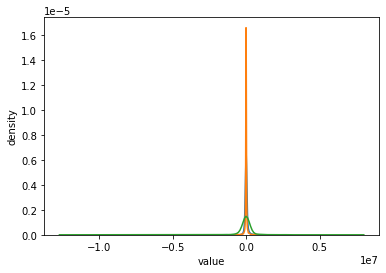

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df[df["Market"] == "Chicago, IL"]["revenue_diff"],label='Chicago (CBD)')
sns.kdeplot(df[df["Market"] == "Houston, TX"]["revenue_diff"],label='Houston')
sns.kdeplot(df[df["Market"] == "Miami/Hialeah, FL"]["revenue_diff"],label='Miami/Hialeah, FL')

# beautifying the labels
plt.xlabel('value')
plt.ylabel('density')
plt.show()

In [251]:
df

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,Revenue_cf,Revenue_ne,revenue_diff,ps_cf,ps_ne,ps_diff,cost_diff,market_share_sum_diff,price_diff,market_share_diff
0,4233,2016-01,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,...,4.729960e+05,4.759423e+05,-2946.293221,68844.756404,68857.442789,-12.686386,-2933.606836,-0.000501,0.146333,-0.000020
1,4234,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,...,1.134177e+06,1.116667e+06,17510.400161,40053.558759,38464.722516,1588.836243,15921.563918,-0.000501,0.282914,0.000043
2,4235,2016-01,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,...,2.116782e+05,2.108743e+05,803.899757,23897.702609,23773.405040,124.297568,679.602189,-0.000501,0.044569,0.000003
3,4236,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,...,6.395866e+05,6.313484e+05,8238.174238,10543.857272,9730.393344,813.463928,7424.710309,-0.000501,0.365288,0.000019
4,4237,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,...,2.148987e+06,2.152802e+06,-3814.370190,209104.425948,207771.090169,1333.335779,-5147.705969,-0.000501,0.170036,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5514,410,2016-11,110924,2016-11-01,2257.0,2061.0,231913.00,91.3159,112.524503,102.752769,...,2.312369e+05,3.287302e+05,-97493.334065,87812.423947,144703.676435,-56891.252488,-40602.081577,-0.007009,14.362939,-0.003970
5515,412,2016-11,740551,2016-11-01,1920.0,1890.0,210145.00,98.4375,111.187831,109.450521,...,2.217694e+05,3.511145e+05,-129345.078454,113559.222032,134684.408166,-21125.186134,-108219.892320,-0.007009,21.899008,-0.005946
5516,421,2016-11,5110932,2016-11-01,2248.0,1979.0,323607.00,88.0338,163.520465,143.953292,...,3.276993e+05,4.072227e+05,-79523.440458,38033.586690,108527.708030,-70494.121340,-9029.319118,-0.007009,8.125207,-0.001892
5544,435,2016-12,81425,2016-12-01,1395.0,1194.0,184907.00,85.5913,154.863484,132.549821,...,1.934621e+05,2.019873e+05,-8525.169067,-56968.196101,-48606.610345,-8361.585756,-163.583311,-0.002546,1.532331,-0.000209
